# Keterangan Tugas

Film Junky Union, sebuah komunitas baru bagi penggemar film klasik sedang mengembangkan sistem untuk memfilter dan mengategorikan ulasan film. Misi utamanya adalah melatih model agar bisa mendeteksi ulasan negatif secara otomatis. Anda akan menggunakan *dataset* ulasan film IMBD dengan pelabelan polaritas untuk membuat sebuah model yang bisa mengklasifikasikan ulasan positif dan negatif. Model ini setidaknya harus memiliki skor F1 sebesar 0,85.

## Inisialisasi

In [3]:
import math

import numpy as np
import pandas as pd
import re

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# baris berikutnya menyediakan grafik dengan kualitas yang lebih baik di layar HiDPI 

# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [5]:
# ini untuk menggunakan progress_apply, baca lebih lanjut di https://pypi.org/project/tqdm/# pandas-integration
tqdm.pandas()

## Memuat data

In [6]:
try:
    df_reviews = pd.read_csv('D:/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
except:
    df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [7]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [8]:
df_reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

Ada dua nilai yang hilang pada data. Namun, kita tidak akan mengisi ataupun menghapusnya. Dikarenakan data yang kita akan uji adalah data pada kolom review dan pos. Serta, karena kecilnya jumlah data yang hilang tersebut tidak akan memengaruhi hasil analisis.

## EDA

Periksa jumlah film dan ulasan selama beberapa tahun.

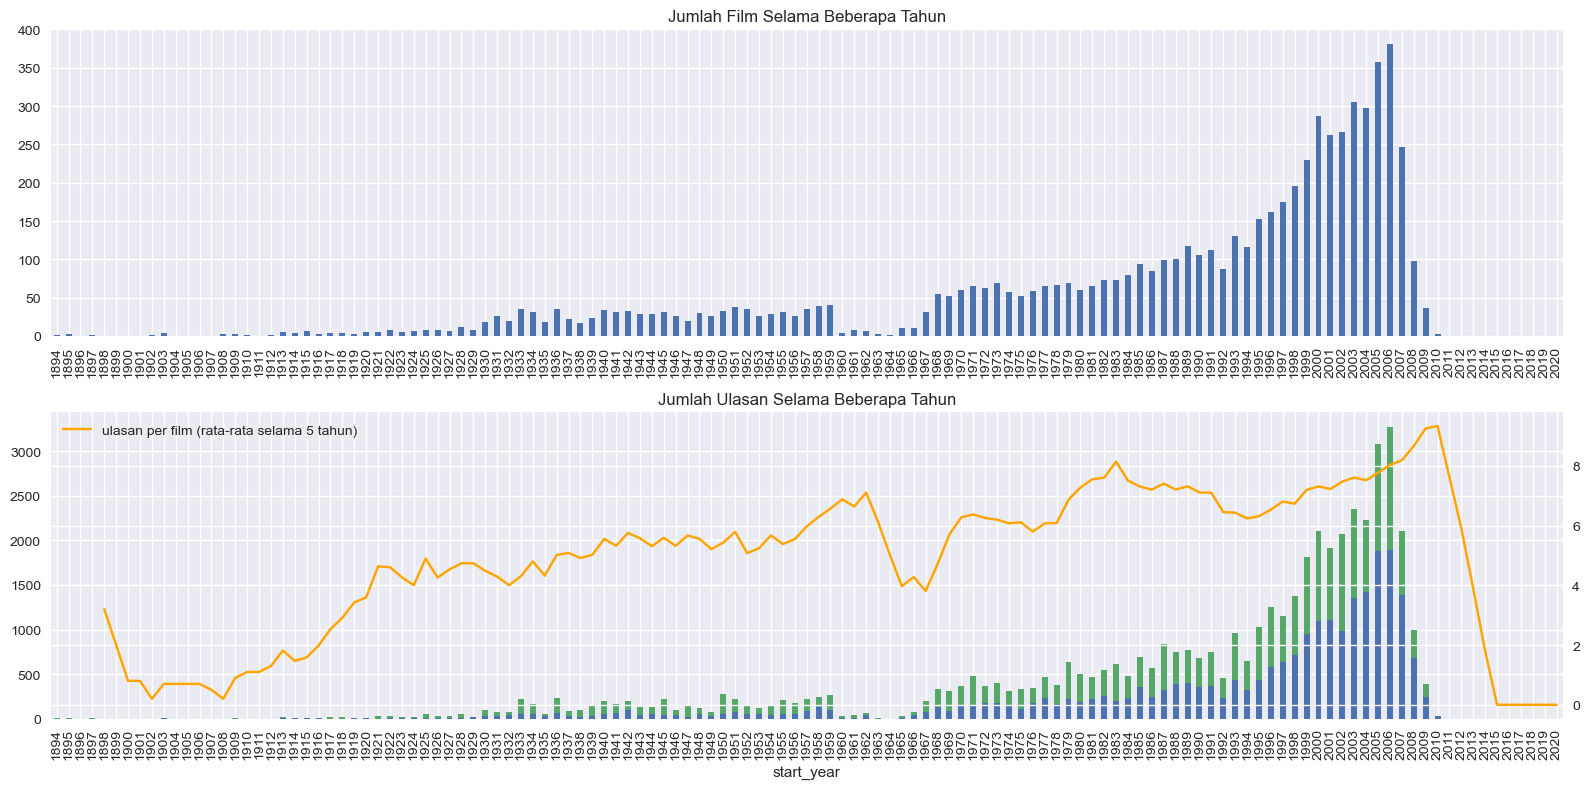

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Jumlah Film Selama Beberapa Tahun')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#ulasan  (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='ulasan per film (rata-rata selama 5 tahun)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Jumlah Ulasan Selama Beberapa Tahun') 

fig.tight_layout()

Periksa distribusi jumlah ulasan per film dengan penghitungan yang tepat dan KDE (hanya untuk mengetahui perbedaannya dari penghitungan yang tepat)

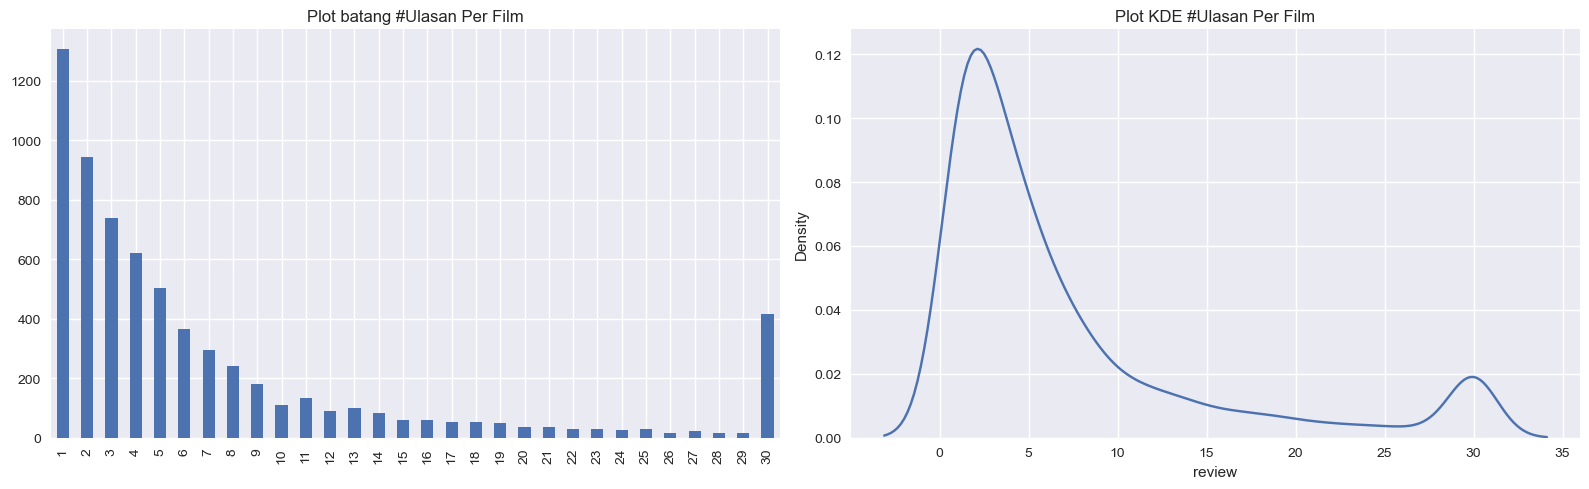

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Plot batang #Ulasan Per Film')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Plot KDE #Ulasan Per Film') 

fig.tight_layout()

In [11]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

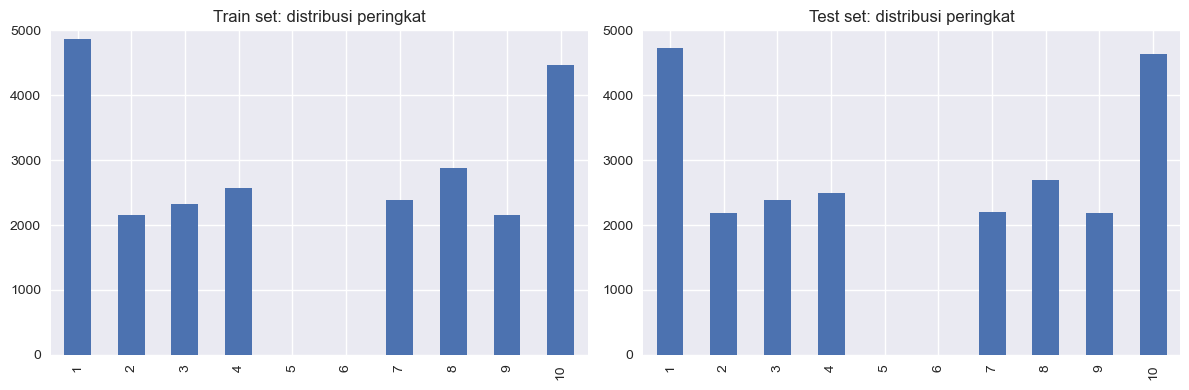

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Train set: distribusi peringkat')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Test set: distribusi peringkat')

fig.tight_layout()

Distribusi ulasan negatif dan positif selama bertahun-tahun untuk dua bagian *dataset*

C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:1708: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


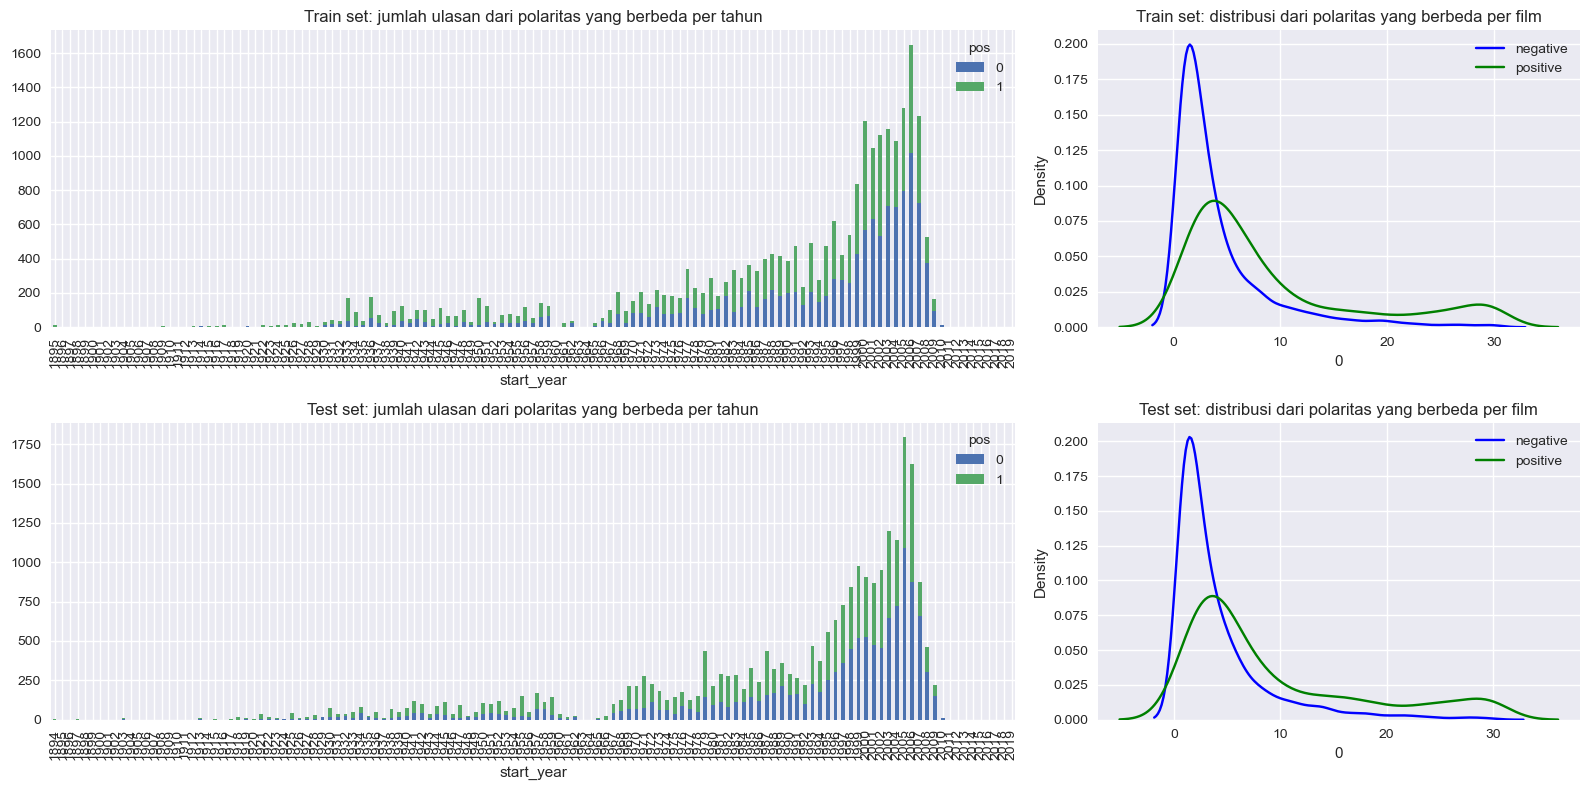

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Train set: jumlah ulasan dari polaritas yang berbeda per tahun')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('Train set: distribusi dari polaritas yang berbeda per film')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Test set: jumlah ulasan dari polaritas yang berbeda per tahun')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('Test set: distribusi dari polaritas yang berbeda per film')

fig.tight_layout()

## Prosedur Evaluasi

Menyusun evaluasi yang dapat digunakan untuk semua model dalam tugas ini secara rutin

In [14]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for tipe, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[tipe] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[tipe]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[tipe]['APS'] = aps
        
        if tipe == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Scor F1 
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{tipe}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Skor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{tipe}, ROC AUC={roc_auc:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Kurva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{tipe}, AP={aps:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[tipe]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[tipe]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return 

## Normalisasi

Kita menganggap semua model di bawah menerima teks dalam huruf kecil dan tanpa angka, tanda baca, dll.

In [15]:
# fungsi normalisasi
def normalize(text):
    pattern = r'[^a-zA-Z]'
    processed = re.sub(pattern, " ", text)
    processed = " ".join(processed.split())
    return processed.lower()

normalize_text = []
for i in range(len(df_reviews['review'])):
    normalize_text.append(normalize(df_reviews.loc[i]['review']))
    
df_reviews['review_norm'] = normalize_text

In [16]:
df_reviews['review_norm'].head()

0    the pakage implies that warren beatty and gold...
1    how the hell did they get this made presenting...
2    there is no real story the film seems more lik...
3    um a serious film about troubled teens in sing...
4    i m totally agree with garryjohal from singapo...
Name: review_norm, dtype: object

## Pemisahan Train / Test

Untungnya, seluruh *dataset* sudah dibagi menjadi *train/test*. Bendera yang sesuai adalah 'ds_part'.

In [17]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Bekerja dengan Model

### Model 0 - Konstan

In [18]:
from sklearn.dummy import DummyClassifier

In [19]:
dummy_model = DummyClassifier(strategy='uniform', random_state=42)

In [20]:
dummy_model.fit(df_reviews_train, train_target)

DummyClassifier(random_state=42, strategy='uniform')

In [21]:
dummy_model.predict(df_reviews_test)

array([0, 1, 0, ..., 0, 1, 1], dtype=int64)

In [22]:
dummy_model.score(df_reviews_train, train_target)

0.5068078668683812

### Model 1 - NLTK, TF-IDF dan LR

TF-IDF

In [75]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [80]:
import nltk
nltk.download('stopwords')

# membuat stopwords dan membuat vectorizer
stop_words = set(stopwords.words('english'))
count_tf_idf1 = TfidfVectorizer(stop_words=list(stop_words))

# mengambil corpus dari data test dan data train
corpus_train = df_reviews_train['review_norm']
corpus_test = df_reviews_test['review_norm']

# menerapkan tf-idf pada corpus
train_features_1 = count_tf_idf1.fit_transform(corpus_train)
test_features_1 = count_tf_idf1.transform(corpus_test)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [82]:
# # membuat model
model_1 = LogisticRegression()
model_1.fit(train_features_1, train_target)

LogisticRegression()

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


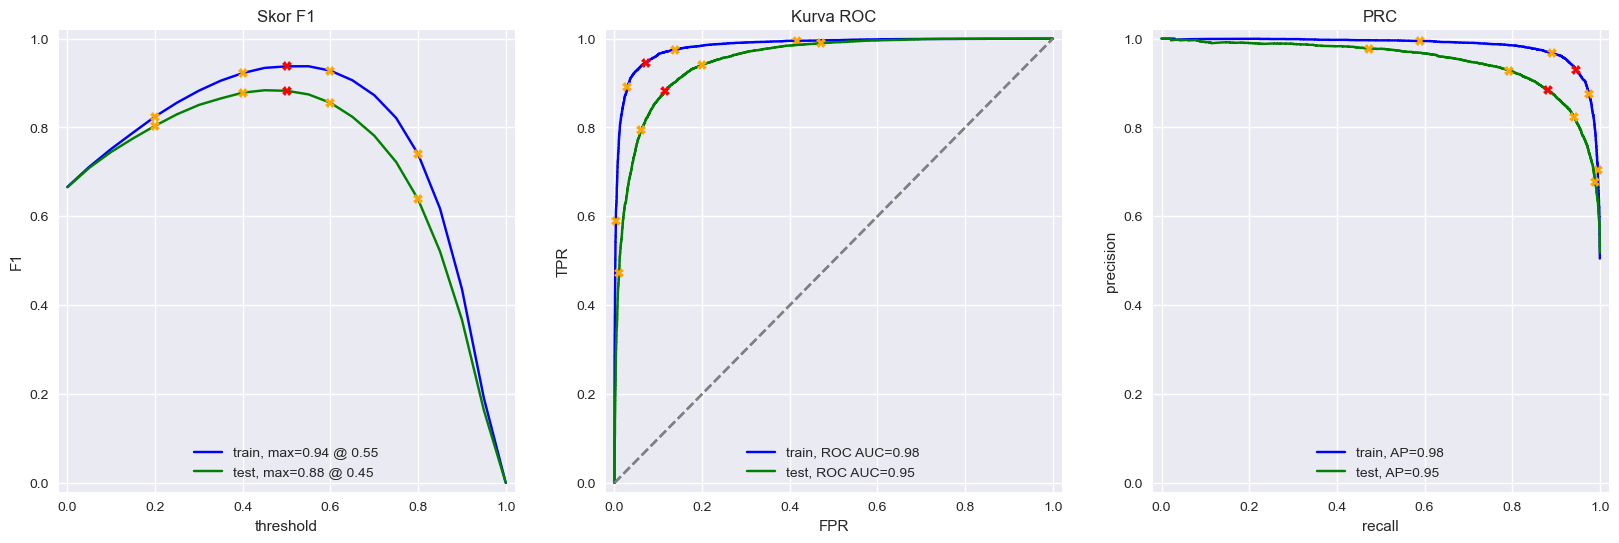

In [83]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Model 3 - spaCy, TF-IDF dan LR

In [84]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [85]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [29]:
# menerapkan tokenisasi spaCy pada data test dan training
review_train = df_reviews_train['review_norm'].apply(text_preprocessing_3)
review_test = df_reviews_test['review_norm'].apply(text_preprocessing_3)

In [86]:
# menerapkan tf-idf
count_tf_idf3 = TfidfVectorizer(stop_words=list(stop_words))
train_feature_3 = count_tf_idf3.fit_transform(review_train)
test_feature_3 = count_tf_idf3.transform(review_test)

In [87]:
# melatih model
model_3 = LogisticRegression()
model_3.fit(train_feature_3, train_target)

LogisticRegression()

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


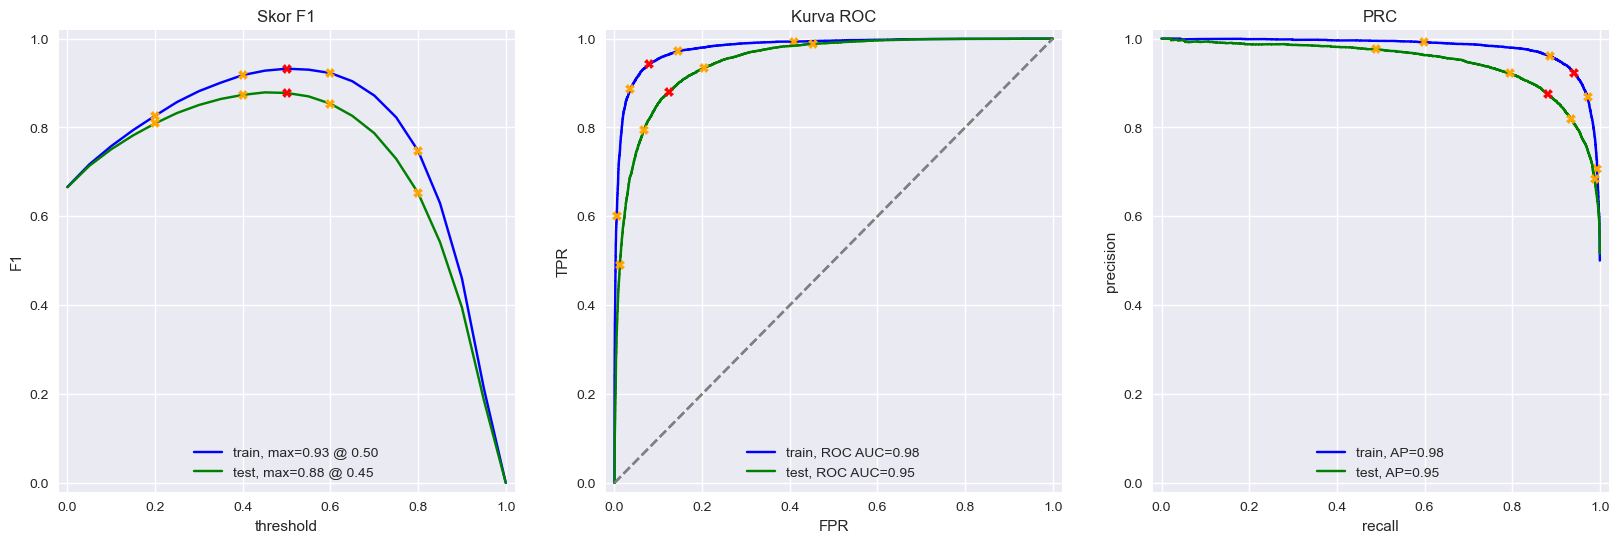

In [88]:
evaluate_model(model_3, train_feature_3, train_target, test_feature_3, test_target)

### Model 4 - spaCy, TF-IDF dan LGBMClassifier

In [33]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

In [34]:
# melakukan hyperparameter tuning
model_4 = LGBMClassifier()
param_grid = {
    'num_leaves':[20, 100],
    'n_estimators':[50, 100],
    'learning_rate':[0.1, 0.5],
    'objective':['binary']
}
grid_cv = GridSearchCV(estimator=model_4, param_grid=param_grid, cv=5, n_jobs=-1)
grid_cv.fit(train_feature_3, train_target)
best_params = grid_cv.best_params_
print("Parameter terbaik:", best_params)

Parameter terbaik: {'learning_rate': 0.5, 'n_estimators': 100, 'num_leaves': 100, 'objective': 'binary'}


          train  test
Accuracy    1.0  0.86
F1          1.0  0.86
APS         1.0  0.94
ROC AUC     1.0  0.94


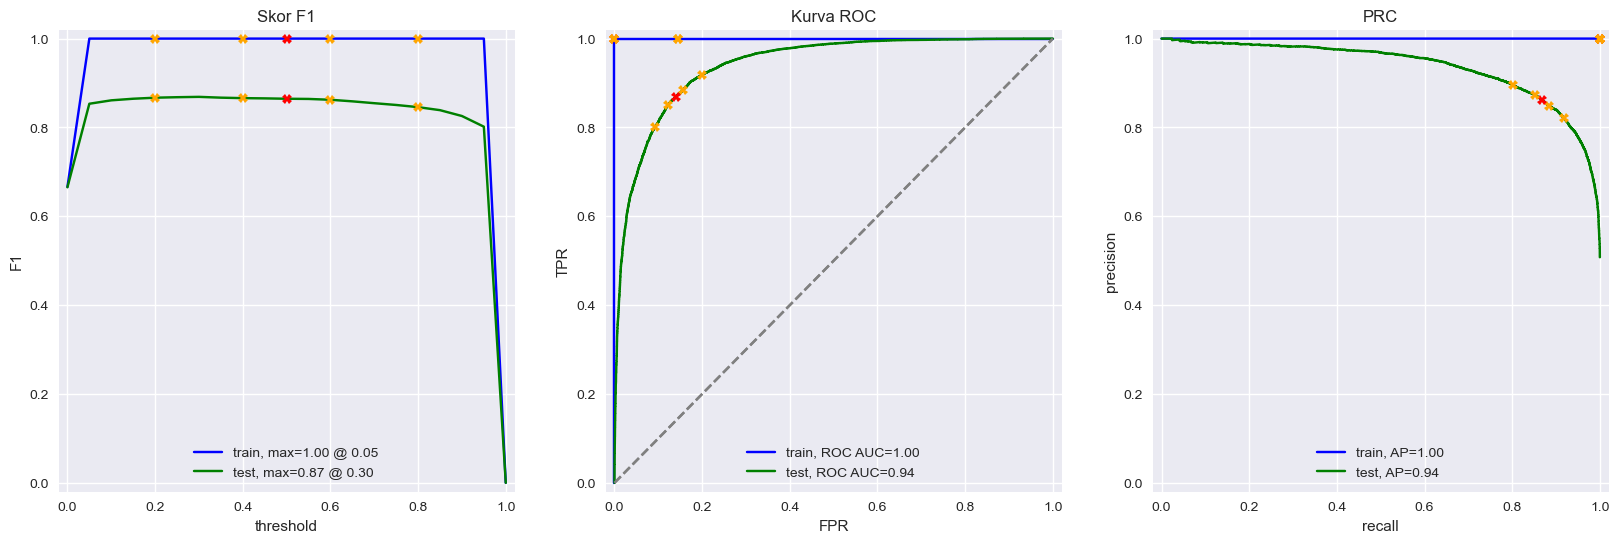

In [210]:
model_fix = LGBMClassifier(learning_rate=0.5, n_estimators=100, num_leaves=100, objective='binary', random_state=42)
model_fix.fit(train_feature_3, train_target)
evaluate_model(model_fix, train_feature_3, train_target, test_feature_3, test_target)

### Model 9 - BERT

In [1]:
import torch
import transformers

In [2]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [237]:
sample_size=200
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # teks ke id token yang sudah di-padded bersamaan dengan attention mask
    
    # <masukkan kode di sini untuk ids_list dan attention_mask_list>
    for text in tqdm(texts, disable=disable_progress_bar):
        ids = tokenizer.encode(text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Gunakan {device} perangkat.')
    
    # dapatkan embedding dalam batch 

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <masukkan kode di sini untuk membuat attention_mask_batch
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [238]:
# Perhatian! Menjalankan BERT untuk ribuan teks mungkin memakan waktu lama di CPU, setidaknya beberapa jam
train_features_9 = BERT_text_to_embeddings(df_reviews_train.iloc[:sample_size]['review_norm'], force_device='cpu')

  0%|          | 0/200 [00:00<?, ?it/s]

Gunakan cpu perangkat.


  0%|          | 0/2 [00:00<?, ?it/s]

In [239]:
test_features_9 = BERT_text_to_embeddings(df_reviews_test[:sample_size]['review_norm'], force_device='cpu')

  0%|          | 0/200 [00:00<?, ?it/s]

Gunakan cpu perangkat.


  0%|          | 0/2 [00:00<?, ?it/s]

In [240]:
print("All Train Set:")
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)
print()
print("All Test Set:")
print(df_reviews_test['review_norm'].shape)
print(test_features_9.shape)
print(test_target.shape)

All Train Set:
(23796,)
(200, 768)
(23796,)

All Test Set:
(23535,)
(200, 768)
(23535,)


In [241]:
# jika sudah mendapatkan embedding, disarankan untuk menyimpannya agar siap 
np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# dan muat...
with np.load('features_9.npz') as data:
    train_features_9 = data['train_features_9']
    test_features_9 = data['test_features_9']

In [242]:
# ambil 200 data pada target
sample_train_target = train_target.iloc[:sample_size]
sample_test_target = test_target.iloc[:sample_size]

In [243]:
# melakukan hyperparameter tuning
model_9 = LGBMClassifier()
param_grid = {
    'num_leaves':[20, 100],
    'n_estimators':[50, 100],
    'learning_rate':[0.1, 0.5],
    'objective':['binary'], 
    'random_state':[42]
}
grid_cv_9 = GridSearchCV(estimator=model_9, param_grid=param_grid, cv=5, n_jobs=-1)
grid_cv_9.fit(train_features_9, sample_train_target)
best_params_9 = grid_cv_9.best_params_

In [244]:
print("Skor Terbaik:", grid_cv_9.best_score_)
print("Parameter terbaik:", best_params_9)

Skor Terbaik: 0.805
Parameter terbaik: {'learning_rate': 0.5, 'n_estimators': 50, 'num_leaves': 20, 'objective': 'binary', 'random_state': 42}


In [250]:
# melatih model dan mengujinya
model_fix_9 = LGBMClassifier(learning_rate=0.5, n_estimators=50, num_leaves=20, objective='binary', random_state=42)
model_fix_9.fit(train_features_9, sample_train_target)

LGBMClassifier(learning_rate=0.5, n_estimators=50, num_leaves=20,
               objective='binary', random_state=42)

          train  test
Accuracy    1.0  0.70
F1          1.0  0.65
APS         1.0  0.86
ROC AUC     1.0  0.85


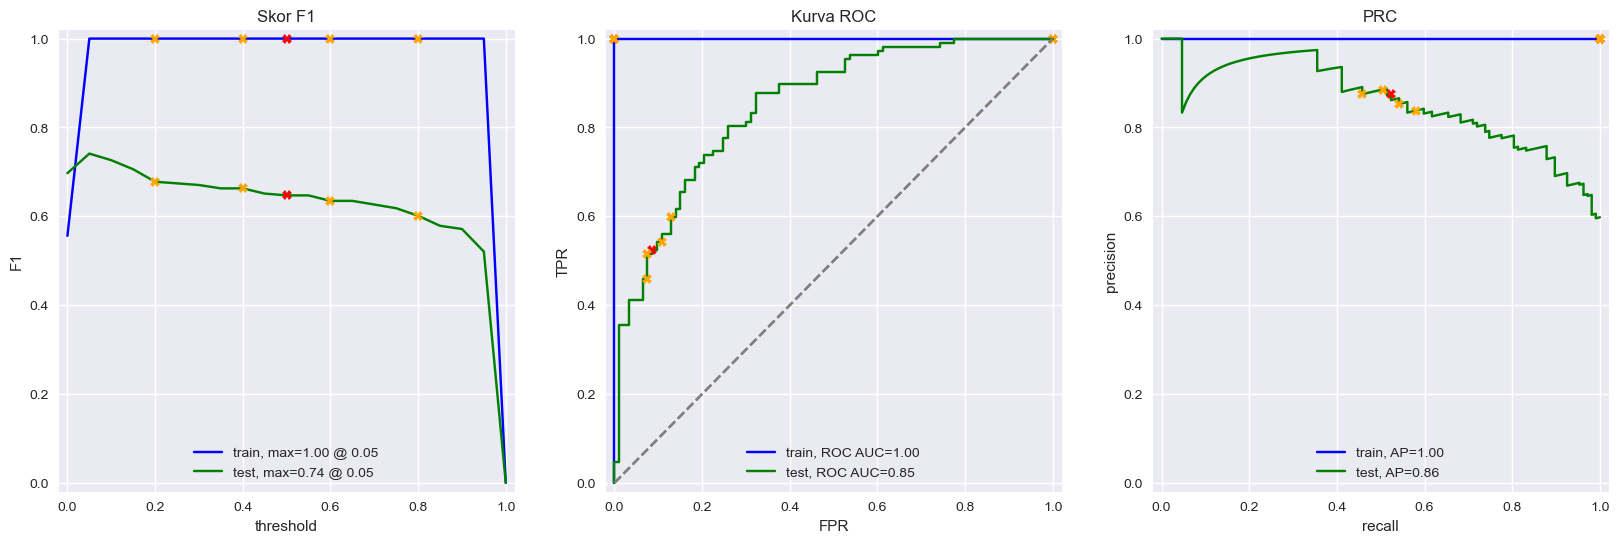

In [251]:
evaluate_model(model_fix_9, train_features_9, sample_train_target, test_features_9, sample_test_target)

## Ulasan Saya

In [252]:
# jangan ragu untuk menghapus ulasan ini dan mencoba model Anda sendiri terhadap ulasan Anda, ini hanyalah sekadar contoh 

my_reviews = pd.DataFrame([
    'saya tidak begitu menyukainya, bukan jenis film kesukaan saya.', 
    'Membosankan, bahkan saya tidur di tengah-tengah film.', 
    'Filmnya sangat bagus, saya sangat suka',     
    'Bahkan para aktornya terlihat sangat tua dan tidak tertarik dengan filmnya, apakah mereka dibayar untuk bermain film. Sungguh tidak bermutu.', 
    'Saya tidak menyangka filmnya sebagus ini! Para penulis sungguh memperhatikan tiap detailnya', 
    'Film ini memiliki kelebihan dan kekurangan, tetapi saya merasa secara keseluruhan ini adalah film yang layak. Saya mungkin akan menontonnya lagi.', 
    'Beberapa lawakannya sungguh tidak lucu. Tidak ada satu pun lelucon yang berhasil, semua orang bertingkah menyebalkan, bahkan anak-anak pun tidak akan menyukai ini!', 
    'Menayangkan film ini di Netflix adalah langkah yang berani & saya sangat senang bisa menonton episode demi episode dari drama baru yang menarik dan cerdas ini.' 
], columns=['review'])

prosessed = []
for i in range(my_reviews.shape[0]):
    prosessed.append(normalize(my_reviews.iloc[i]['review']))
    
my_reviews['review_norm'] = prosessed

my_reviews

,review,review_norm
0,"saya tidak begitu menyukainya, bukan jenis fil...",saya tidak begitu menyukainya bukan jenis film...
1,"Membosankan, bahkan saya tidur di tengah-tenga...",membosankan bahkan saya tidur di tengah tengah...
2,"Filmnya sangat bagus, saya sangat suka",filmnya sangat bagus saya sangat suka
3,Bahkan para aktornya terlihat sangat tua dan t...,bahkan para aktornya terlihat sangat tua dan t...
4,Saya tidak menyangka filmnya sebagus ini! Para...,saya tidak menyangka filmnya sebagus ini para ...
5,"Film ini memiliki kelebihan dan kekurangan, te...",film ini memiliki kelebihan dan kekurangan tet...
6,Beberapa lawakannya sungguh tidak lucu. Tidak ...,beberapa lawakannya sungguh tidak lucu tidak a...
7,Menayangkan film ini di Netflix adalah langkah...,menayangkan film ini di netflix adalah langkah...


### Model 2

In [253]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(count_tf_idf1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.65:  saya tidak begitu menyukainya bukan jenis film kesukaan saya
0.51:  membosankan bahkan saya tidur di tengah tengah film
0.48:  filmnya sangat bagus saya sangat suka
0.47:  bahkan para aktornya terlihat sangat tua dan tidak tertarik dengan filmnya apakah mereka dibayar unt
0.46:  saya tidak menyangka filmnya sebagus ini para penulis sungguh memperhatikan tiap detailnya
0.54:  film ini memiliki kelebihan dan kekurangan tetapi saya merasa secara keseluruhan ini adalah film yan
0.39:  beberapa lawakannya sungguh tidak lucu tidak ada satu pun lelucon yang berhasil semua orang bertingk
0.59:  menayangkan film ini di netflix adalah langkah yang berani saya sangat senang bisa menonton episode 


### Model 3

In [254]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(count_tf_idf3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.64:  saya tidak begitu menyukainya bukan jenis film kesukaan saya
0.51:  membosankan bahkan saya tidur di tengah tengah film
0.48:  filmnya sangat bagus saya sangat suka
0.46:  bahkan para aktornya terlihat sangat tua dan tidak tertarik dengan filmnya apakah mereka dibayar unt
0.45:  saya tidak menyangka filmnya sebagus ini para penulis sungguh memperhatikan tiap detailnya
0.53:  film ini memiliki kelebihan dan kekurangan tetapi saya merasa secara keseluruhan ini adalah film yan
0.39:  beberapa lawakannya sungguh tidak lucu tidak ada satu pun lelucon yang berhasil semua orang bertingk
0.62:  menayangkan film ini di netflix adalah langkah yang berani saya sangat senang bisa menonton episode 


### Model 4

In [255]:
texts = my_reviews['review_norm']

count_tf_idf4 = count_tf_idf3
my_reviews_pred_prob = model_fix.predict_proba(count_tf_idf4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.73:  saya tidak begitu menyukainya bukan jenis film kesukaan saya
0.73:  membosankan bahkan saya tidur di tengah tengah film
0.47:  filmnya sangat bagus saya sangat suka
0.63:  bahkan para aktornya terlihat sangat tua dan tidak tertarik dengan filmnya apakah mereka dibayar unt
0.47:  saya tidak menyangka filmnya sebagus ini para penulis sungguh memperhatikan tiap detailnya
0.73:  film ini memiliki kelebihan dan kekurangan tetapi saya merasa secara keseluruhan ini adalah film yan
0.47:  beberapa lawakannya sungguh tidak lucu tidak ada satu pun lelucon yang berhasil semua orang bertingk
0.94:  menayangkan film ini di netflix adalah langkah yang berani saya sangat senang bisa menonton episode 


### Model 9

In [256]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)
my_reviews_pred_prob = model_fix_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.00:  saya tidak begitu menyukainya bukan jenis film kesukaan saya
0.00:  membosankan bahkan saya tidur di tengah tengah film
0.00:  filmnya sangat bagus saya sangat suka
0.00:  bahkan para aktornya terlihat sangat tua dan tidak tertarik dengan filmnya apakah mereka dibayar unt
0.00:  saya tidak menyangka filmnya sebagus ini para penulis sungguh memperhatikan tiap detailnya
0.00:  film ini memiliki kelebihan dan kekurangan tetapi saya merasa secara keseluruhan ini adalah film yan
0.01:  beberapa lawakannya sungguh tidak lucu tidak ada satu pun lelucon yang berhasil semua orang bertingk
0.00:  menayangkan film ini di netflix adalah langkah yang berani saya sangat senang bisa menonton episode 


## Kesimpulan

**Analisis EDA:**
Seperti yang sudah dilihat, bahwa kita memiliki banyak review dari tahun ke tahun secara meningkat. Sampai pada puncaknya yaitu pada tahun 2006. Setelah tahun 2006, jumlah review yang kita punya menurun. Hal ini mungkin disebabkan karena orang yang menonton sudah jarang memberikan review dikarenakan pembajakan film.

**Analasis Modul:**
Modul yang paling bagus dalam mengklasifikasi antara kelas positif dan negatif adalah Logistic Regression. Dengan nilai F1 Score adalah 0.95 pada data train dan 0.88 pada data testing begitupun untuk nilai akurasi. Untuk model LightGBM  memiliki nilai akurasi 1.0 dan F1 Score 0.86. Memang lebih bagus pada model LGBM namun dikhawatirkan ada overfitting karena nilai pada data train yang terlalu bagus. 

Pada modul 9 menggunakan BERT mendapatkan nilai yang sangat rendah bahkan di bawah nilai yang ditentukan. Hal ini mungkin terjadi karena kurangnya data training dan data testing.

**Analisis untu Data Ulasan Saya:**
- Model 2 memberikan nilai yang sangat rendah pada review ke-4 dan ke-5 padahal keduanya adalah review yang positif. Sedangkan pada review yang pertama, diberikan nilai yang begitu tinggi padahal itu adalah review yang positif.
- Model 3 memberikan nilai yang cukup bagus pada sentimen ke-7. Tetapi, ada beberapa sentimen positif malah dianggap negatif oleh model.
- Model 4 memberikan nilai yang cukup bagus, apalagi pada sentimen ke-7 mendapatkan 0.94 skor. Tapi, masih ada sentimen yang tidak sesuai dengan klasifikasinya. Contoh pada sentimen pertama, kedua, dan ketiga.
- Model 9 memberikan nilai yang sangat rendah. Semua sentimen diberikan nilai 0.

# Daftar Periksa

- [x]  *Notebook* dibuka 
- [x]  Data teks telah dimuat dan dilakukan pra-pemrosesan untuk vektorisasi 
- [x]  Data teks telah diubah menjadi vektor 
- [x]  Model telah terlatih dan diuji 
- [x]  Ambang batas metrik tercapai 
- [x]  Semua kode sel tersusun sesuai urutan eksekusinya 
- [x]  Semua kode sel bisa dieksekusi tanpa *error* 
- [x]  Terdapat kesimpulan 